In [15]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime
import tensorflow as tf;
from six.moves import cPickle as pickle;
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
py.init_notebook_mode(connected=True)

In [2]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = 'data/{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, authtoken="rGwyAH1yyw29yX8E1LQJ", returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [3]:
exchanges = ['KRAKEN', 'COINBASE', 'BITFINEX']

exchange_data = {}

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    btc_exchange_df = btc_exchange_df.replace(0, np.NaN) # Wack Kraken values ˜
    exchange_data[exchange] = btc_exchange_df

print(exchange_data)

btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')
print(list(exchange_data['COINBASE'].columns))

Loaded BCHARTS/KRAKENUSD from cache
Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITFINEXUSD from cache
{'KRAKEN':                   Open        High         Low       Close  Volume (BTC)  \
Date                                                                       
2014-01-07   874.67040   892.06753   810.00000   810.00000     15.622378   
2014-01-08   810.00000   899.84281   788.00000   824.98287     19.182756   
2014-01-09   825.56345   870.00000   807.42084   841.86934      8.158335   
2014-01-10   839.99000   857.34056   817.00000   857.33056      8.024510   
2014-01-11   858.20000   918.05471   857.16554   899.84105     18.748285   
2014-01-12   899.96114   900.93989   833.00001   860.00000     25.429433   
2014-01-13   847.32152   859.99999   815.00000   835.00000     25.869127   
2014-01-14   835.00000   877.29300   805.00000   831.00000     31.662881   
2014-01-15   831.00000   864.00000   828.00000   850.00364      6.707565   
2014-01-16   853.00000   865.00000   824.

In [4]:
# Merging data together to create one consistent set 
# Basically does a left join on all three data sets and gets the mean of all values
# Prevents weird discrepencies in the data 

new = pd.merge(exchange_data['KRAKEN'], exchange_data['COINBASE'], how='left', left_index=True, right_index=True)
new = pd.merge(new, exchange_data['BITFINEX'], how='left', left_index=True, right_index=True)
new['new_open'] = new[['Open', 'Open_x', 'Open_y']].mean(axis=1)
new['new_high'] = new[['High_x', 'High_y', 'High']].mean(axis=1)
new['new_low'] = new[['Low_x', 'Low_y', 'Low']].mean(axis=1)
new['new_close'] = new[['Close_x', 'Close_y', 'Close_y']].mean(axis=1)
new['new_btc_volume'] = new[['Volume (BTC)_x', 'Volume (BTC)_y', 'Volume (BTC)']].mean(axis=1)
new['new_currency_volume'] = new[['Volume (Currency)_x', 'Volume (Currency)_y', 'Volume (Currency)']].mean(axis=1)
new['new_weighted_price'] = new[['Weighted Price_x', 'Weighted Price_y', 'Weighted Price']].mean(axis=1)

df = new[['new_open', 'new_high', 'new_low', 'new_close', 'new_btc_volume', 'new_currency_volume', 'new_weighted_price']]

print(df.head())

              new_open    new_high    new_low  new_close  new_btc_volume  \
Date                                                                       
2014-01-07  899.835200  917.608765  787.50000  810.00000    14304.543423   
2014-01-08  804.500000  874.421405  783.79500  824.98287     8859.210857   
2014-01-09  826.681725  858.175000  793.70542  841.86934     7730.399738   
2014-01-10  831.495000  858.990280  808.49000  857.33056     3936.155313   
2014-01-11  855.650000  916.527355  855.08277  899.84105     5584.761975   

            new_currency_volume  new_weighted_price  
Date                                                 
2014-01-07         1.217606e+07          846.521355  
2014-01-08         7.228425e+06          827.526526  
2014-01-09         6.319358e+06          824.516953  
2014-01-10         3.269101e+06          837.727760  
2014-01-11         4.928844e+06          886.605144  


In [5]:
btc_trace = go.Scatter(x=df.index, y=df['new_weighted_price'])
py.iplot([btc_trace])

In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


np.random.seed(7)
# load the dataset
dataset = df.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# # reshape dataset
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testX)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(LSTM(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


[[  657.45635986   654.89331055   624.44000244]
 [  654.89331055   624.44000244   605.22064209]
 [  624.44000244   605.22064209   539.19952393]
 ..., 
 [ 5787.          5751.00488281  6137.90478516]
 [ 5751.00488281  6137.90478516  6124.33007812]
 [ 6137.90478516  6124.33007812  6443.65478516]]


ValueError: Input 0 is incompatible with layer lstm_1: expected ndim=3, found ndim=2

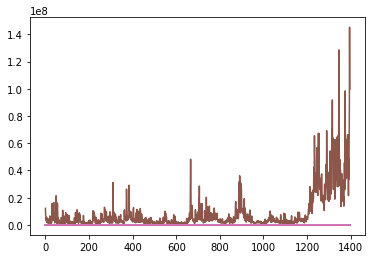

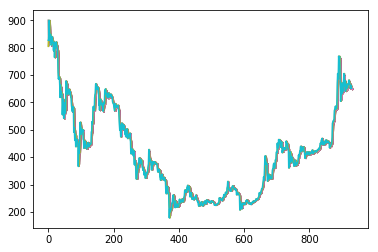

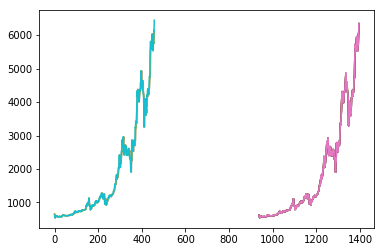

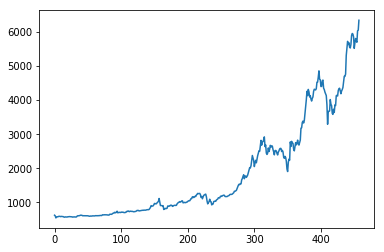

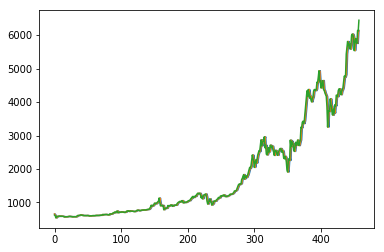

In [11]:
plt.figure(1)
plt.plot(dataset)
plt.figure(2)
plt.plot(trainPredictPlot)
plt.plot(trainX)
plt.figure(3)
plt.plot(testPredictPlot)
plt.plot(testX)
plt.figure(4)
plt.plot(testPredict)
plt.show()

In [12]:
print(testX[-1][-1])
print(testX[-2][-1])
print(testX[-3][-1])
print(testX[-4][-1])
print(testX[-5][-1])

print(testPredict[450:455][::-1])

6443.65
6124.33
6137.9
5751.0
5787.0
[[ 5696.05615234]
 [ 5731.14306641]
 [ 5807.04052734]
 [ 5677.96875   ]
 [ 5516.57128906]]
